In [240]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.DataFrame(pd.read_csv('train.csv'))
data

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0.0
1,2,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0.0
2,3,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0.0
3,4,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0.0
4,5,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0.0
...,...,...,...,...,...,...,...,...,...
824189,969594,NaN,NaN,Zimbabwe,14240168,0.607106,2020-05-18,Fatalities,0.0
824190,969595,NaN,NaN,Zimbabwe,14240168,0.060711,2020-05-19,ConfirmedCases,0.0
824191,969596,NaN,NaN,Zimbabwe,14240168,0.607106,2020-05-19,Fatalities,0.0
824192,969597,NaN,NaN,Zimbabwe,14240168,0.060711,2020-05-20,ConfirmedCases,2.0


In [2]:
countries = data['Country_Region'].unique()
data_by_country=[]
for c in countries:
    c_data = data.loc[data['Country_Region'] == c]
    c_data_cases = c_data.loc[c_data['Target'] == 'ConfirmedCases']
    c_data_cases = c_data_cases.loc[c_data_cases['Population'] == c_data_cases['Population'].values.max()]
    c_data_cases_percent_pop = c_data_cases['TargetValue'].values/c_data_cases['Population'].values.max()*100
    data_by_country.append(c_data_cases_percent_pop)
    #plt.plot(c_data_cases_percent_pop, label = c)
    #plt.legend()
    #plt.show()

In [152]:
#np.where(countries=="United Kingdom")
np.where(countries=="US")
#plt.plot(data_by_country[136], label="Portugal")
#plt.plot(data_by_country[9], label="Austria")
#plt.legend()
#plt.show()

(array([173]),)

# Scoring countries by strictness of lockdown:
https://www.politico.eu/article/europes-coronavirus-lockdown-measures-compared/

One point is added for 
- Events suspended
- All schools closed
- Non-essential shops closed
- Non-essenntial movement banned 
- Land borders closed
- Non-essential production stopped

One point is subtracted for
- Each day that passed before events were suspended after the 3rd COVID-19 death

In [140]:
import numpy as np
score = np.zeros((len(countries),1))

ind = np.where(countries=='Italy')
score[ind]=5-9

ind = np.where(countries=='France') 
score[ind]=4

ind = np.where(countries=='Spain')
score[ind]=6-4

ind = np.where(countries=='United Kingdom')
score[ind]=4-8

ind = np.where(countries=='Belgium')
score[ind]=5-2

ind = np.where(countries=='Germany')
score[ind]=4-8

ind = np.where(countries=='Greece') 
score[ind]=5

ind = np.where(countries=='Poland')
score[ind]=5

ind = np.where(countries=='Sweden')
score[ind]=1

ind = np.where(countries=='Austria') 
score[ind]=4

ind = np.where(countries=='Portugal')
score[ind]=5

ind = np.where(countries=='Hungary')
score[ind]=5

ind = np.where(countries=='Czechia') 
score[ind]=5

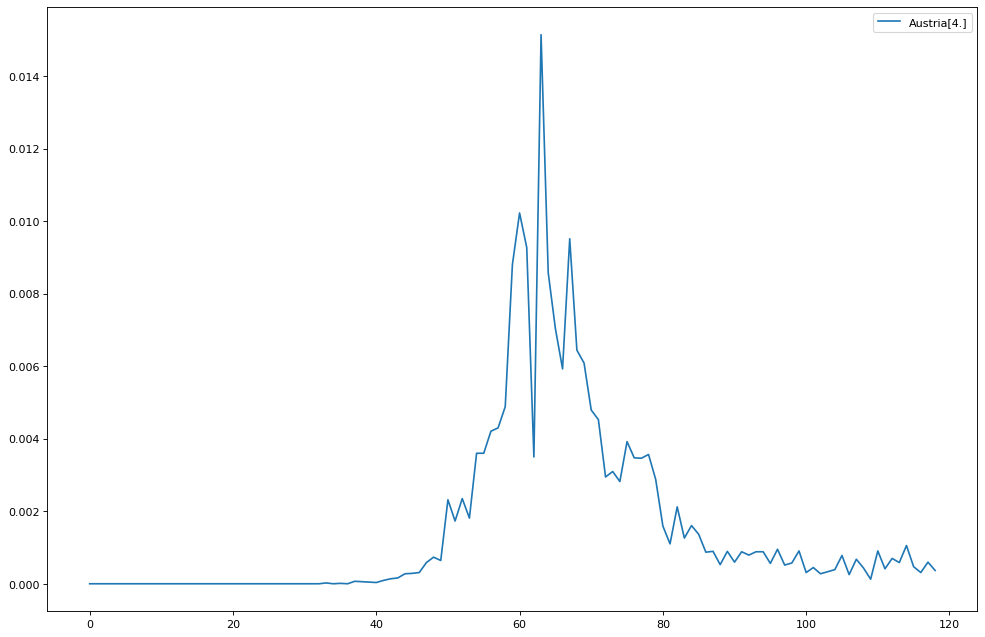

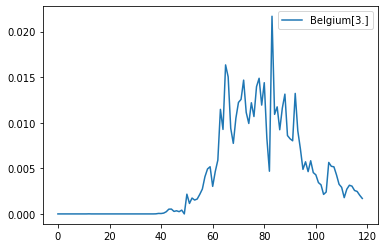

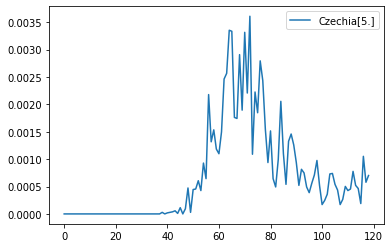

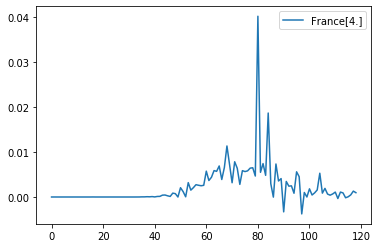

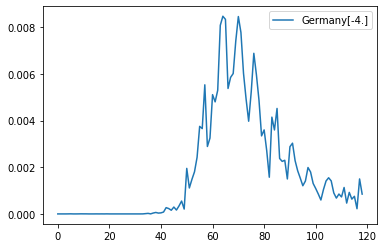

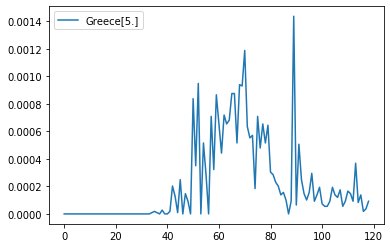

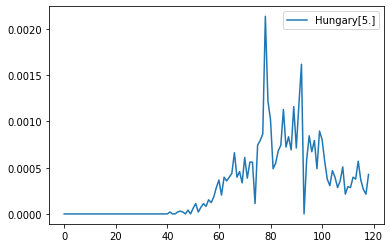

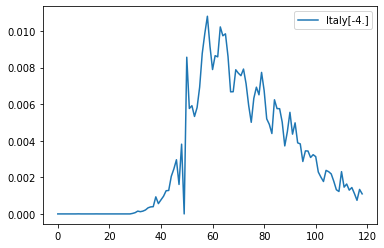

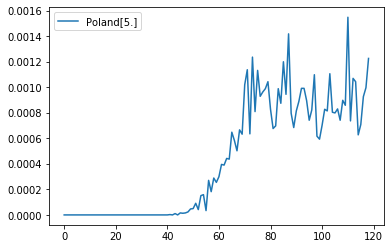

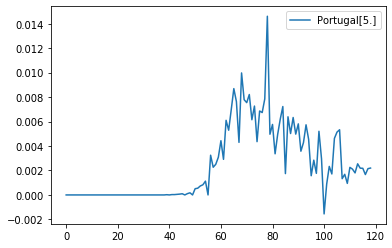

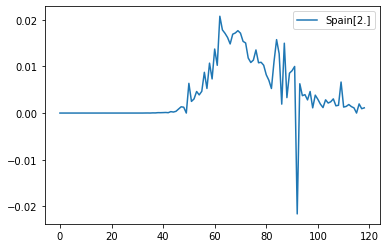

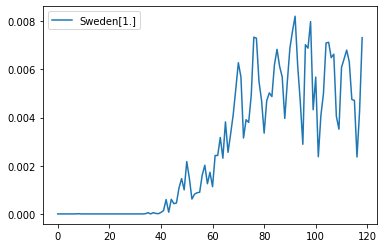

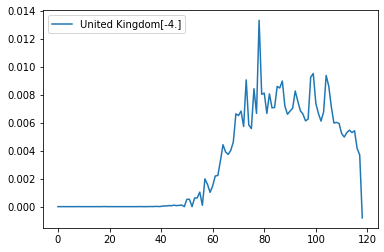

In [141]:
fig=plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
ind = np.where(score!=0)
scores = score[ind[0]]
labeled_data = []
for i in ind[0]:
    labeled_data.append(data_by_country[i])
    plt.plot(data_by_country[i], label = countries[i]+ str(score[i]))
    #plt.title(score[i])
    plt.legend()
    plt.show()

labeled_data= np.vstack(labeled_data)


In [142]:
#ind1 = np.where(scores>3)[0]
#ind0 = np.where(scores<=3)[0]
#scores[ind1]=1
#scores[ind0]=0

In [143]:
scores

array([[ 4.],
       [ 3.],
       [ 5.],
       [ 4.],
       [-4.],
       [ 5.],
       [ 5.],
       [-4.],
       [ 5.],
       [ 5.],
       [ 2.],
       [ 1.],
       [-4.]])

# Predict score based on data
https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

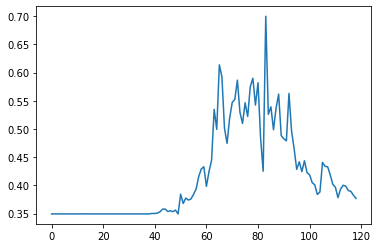

In [144]:
import torch
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
maxval = labeled_data.max()
minval = labeled_data.min()
normalized=(labeled_data-minval)/(maxval-minval)
plt.plot(normalized[1])
train_data = normalized[1:]

In [145]:
def create_inout_sequences(input_data, labels):
    inout_seq = []
    for i in range(len(labels)):
        train_seq = torch.FloatTensor(input_data[i]).view(-1)
        train_label = torch.FloatTensor(labels[i]).view(-1)
        inout_seq.append((train_seq ,train_label))
    return inout_seq
train_inout_seq =create_inout_sequences(train_data, scores[1:])

In [146]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [147]:
model = LSTM()
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [148]:
epochs = 20
losses=[]
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        losses.append(single_loss)
        single_loss.backward()
        optimizer.step()
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 4.26438999
epoch:  19 loss: 7.2636547089


19

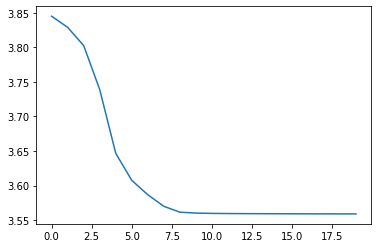

In [149]:
losses=[float(i) for i in losses]
lossperepoch  =[]
sep=int(len(losses)/epochs)
c=0
for i in range(0,len(losses),sep):
    lossperepoch.append(sum(losses[c*sep:c*sep+sep]))
    c=c+1
plt.plot(range(0,epochs),np.log(lossperepoch))
np.argmin(lossperepoch)

In [150]:
model.eval()
seq = torch.FloatTensor(torch.FloatTensor(labeled_data[0]).view(-1))
with torch.no_grad():
    model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
    out=model(seq).item()
print(out)
print(scores[0])

3.2341976165771484
[4.]


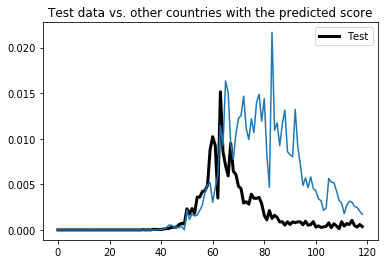

In [61]:
ind = np.where(scores==3.) 
plt.plot(labeled_data[0], label='Test', linewidth = 3, color = 'black')
plt.plot(labeled_data[ind[0][0]])
#plt.plot(labeled_data[ind[0][1]])
#plt.plot(labeled_data[ind[0][2]])
#plt.plot(labeled_data[ind[0][3]])
#plt.plot(labeled_data[ind[0][4]])
#plt.plot(labeled_data[ind[0][5]])
plt.legend()
plt.title("Test data vs. other countries with the predicted score")
plt.show()

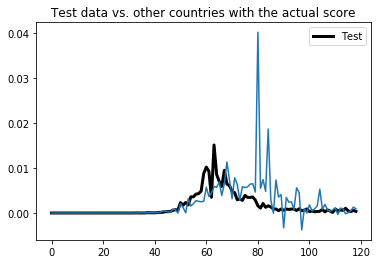

In [63]:
ind = np.where(scores==4.) 
plt.plot(labeled_data[0], label='Test', linewidth = 3, color = 'black')
#plt.plot(labeled_data[ind[0][0]], label='With actual score')
plt.plot(labeled_data[ind[0][1]])
#plt.plot(labeled_data[ind[0][2]])
#plt.plot(labeled_data[ind[0][3]])
#plt.plot(labeled_data[ind[0][4]])
#plt.plot(labeled_data[ind[0][5]])
#plt.plot(labeled_data[ind[0][6]])
plt.legend()
plt.title("Test data vs. other countries with the actual score")
plt.show()

In [153]:
#ind = np.where(scores==5.) 
#plt.plot(labeled_data[ind[0][0]])
#plt.plot(labeled_data[ind[0][1]])
#plt.plot(labeled_data[ind[0][2]])
#plt.plot(labeled_data[ind[0][3]])
#plt.plot(labeled_data[ind[0][4]])

# Comparing Various Countries

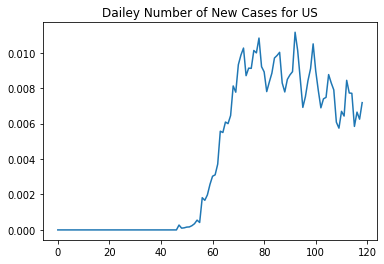

In [154]:
US_data = data.loc[data['Country_Region'] == 'US']
US_data_cases = US_data.loc[US_data['Target'] == 'ConfirmedCases']
US_data_cases = US_data_cases.loc[US_data_cases['Population'] == 324141489]
plt.plot(US_data_cases['TargetValue'].values/324141489*100)
plt.title("Dailey Number of New Cases for US")
plt.show()

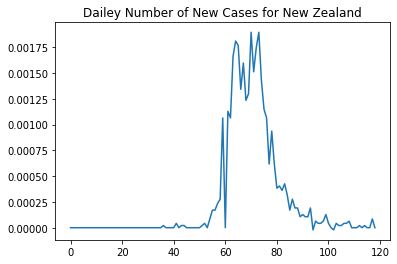

In [155]:
NZ_data = data.loc[data['Country_Region'] == 'New Zealand']
NZ_data_cases = NZ_data.loc[NZ_data['Target'] == 'ConfirmedCases']
NZ_data_cases = NZ_data_cases.loc[NZ_data_cases['Population'] == NZ_data_cases['Population'].values.max()]
plt.plot(NZ_data_cases['TargetValue'].values/NZ_data_cases['Population'].values.max()*100)
plt.title("Dailey Number of New Cases for New Zealand")
plt.show()

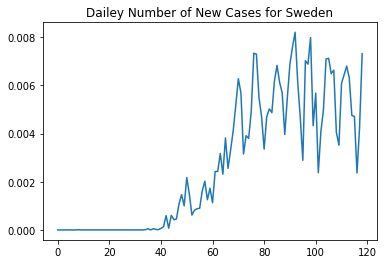

In [156]:
Sweden_data = data.loc[data['Country_Region'] == 'Sweden']
Sweden_data_cases = Sweden_data.loc[Sweden_data['Target'] == 'ConfirmedCases']
Sweden_data_cases = Sweden_data_cases.loc[Sweden_data_cases['Population'] == 9894888]
plt.plot(Sweden_data_cases['TargetValue'].values/9894888*100)
plt.title("Dailey Number of New Cases for Sweden")
plt.show()

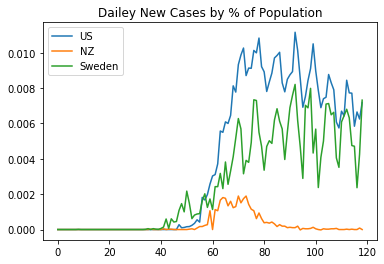

In [157]:
plt.plot(US_data_cases['TargetValue'].values/324141489*100, label='US')
plt.plot(NZ_data_cases['TargetValue'].values/NZ_data_cases['Population'].values.max()*100, label='NZ')
plt.plot(Sweden_data_cases['TargetValue'].values/9894888*100, label='Sweden')
plt.title("Dailey New Cases by % of Population")
plt.legend()
plt.show()

# Let's look at US data state by state

In [241]:
states = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado",
"Connecticut", "District of Columbia", "Delaware", "Florida", "Georgia",
"Hawaii", "Idaho", "Illinois", "Indiana", "Iowa",
"Kansas", "Kentucky", "Louisiana", "Maine", "Maryland",
"Massachusetts", "Michigan", "Minnesota", "Mississippi",
"Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire",
"New Jersey", "New Mexico", "New York", "North Carolina",
"North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania",
"Rhode Island", "South Carolina", "South Dakota", "Tennessee",
"Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia",
"Wisconsin", "Wyoming"]
df_state_cases_data = pd.DataFrame(columns =['Date']+states)#columns = states
df_state_cases_data["Date"] = US_data_cases["Date"].values

In [242]:
data_as_array=[]
for state in states:
    state_data=US_data.loc[US_data['Province_State'] == state]
    state_pop = state_data['Population'].max()
    state_data_cases = state_data.loc[state_data['Target'] == 'ConfirmedCases']
    state_data_cases = state_data_cases.loc[state_data_cases['Population'] == state_pop]
    df_state_cases_data[state]=state_data_cases['TargetValue'].values
    max_cases = df_state_cases_data[state].max()
    min_cases = df_state_cases_data[state].min()
    df_state_cases_data[state]=(df_state_cases_data[state]-min_cases)/(max_cases-min_cases)
    data_as_array.append(df_state_cases_data[state].values)
data_as_array=np.vstack(data_as_array)

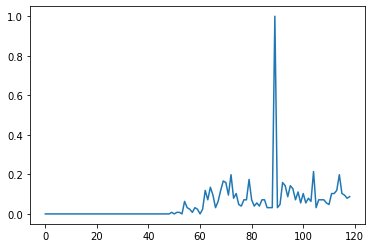

In [265]:
plt.plot(data_as_array[-1])
plt.show()

# Seq2Seq to predict general shape

In [254]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")


latent_dim = 50 # LSTM hidden units
dropout = .20 

encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, 1)) 

decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)

decoder_dense = Dense(1) 
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [255]:
def transform_series_encode(series_array):
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array #- series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    series_array = series_array - np.zeros([len(encode_series_mean),1])#encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [256]:
def create_endoder_target_pairs(data):
    e_data = []
    t_data = []
    if len(data)!=119:
        for i in range(len(data)):
            e_data.append(data[i][0:-40])
            t_data.append(data[i][-40:])
    else:
        e_data.append(data[0:-40])
        t_data.append(data[-40:])
    return [np.array(e_data),np.array(t_data)]
[e_data,t_data]=create_endoder_target_pairs(data_as_array[0:-1])

In [257]:
encoder_input_data = e_data
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = t_data
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [259]:
batch_size = 2**11
epochs = 100

encoder_input_data = e_data
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = t_data
                                            
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2);

Train on 40 samples, validate on 10 samples
Epoch 1/100
40/40 [==============================] - 1s 31ms/step - loss: 0.3029 - val_loss: 0.2789
Epoch 2/100
40/40 [==============================] - 0s 1ms/step - loss: 0.2659 - val_loss: 0.2599
Epoch 3/100
40/40 [==============================] - 0s 1ms/step - loss: 0.2691 - val_loss: 0.2412
Epoch 4/100
40/40 [==============================] - 0s 1ms/step - loss: 0.2139 - val_loss: 0.2228
Epoch 5/100
40/40 [==============================] - 0s 1ms/step - loss: 0.2184 - val_loss: 0.2047
Epoch 6/100
40/40 [==============================] - 0s 2ms/step - loss: 0.1814 - val_loss: 0.1870
Epoch 7/100
40/40 [==============================] - 0s 2ms/step - loss: 0.2118 - val_loss: 0.1705
Epoch 8/100
40/40 [==============================] - 0s 2ms/step - loss: 0.1448 - val_loss: 0.1559
Epoch 9/100
40/40 [==============================] - 0s 2ms/step - loss: 0.1848 - val_loss: 0.1447
Epoch 10/100
40/40 [==============================] - 0s 2ms/ste

Epoch 83/100
40/40 [==============================] - 0s 1ms/step - loss: 0.1615 - val_loss: 0.1474
Epoch 84/100
40/40 [==============================] - 0s 1ms/step - loss: 0.1412 - val_loss: 0.1463
Epoch 85/100
40/40 [==============================] - 0s 1ms/step - loss: 0.1446 - val_loss: 0.1453
Epoch 86/100
40/40 [==============================] - 0s 2ms/step - loss: 0.1469 - val_loss: 0.1444
Epoch 87/100
40/40 [==============================] - 0s 2ms/step - loss: 0.1523 - val_loss: 0.1438
Epoch 88/100
40/40 [==============================] - 0s 2ms/step - loss: 0.1464 - val_loss: 0.1434
Epoch 89/100
40/40 [==============================] - 0s 2ms/step - loss: 0.1425 - val_loss: 0.1430
Epoch 90/100
40/40 [==============================] - 0s 1ms/step - loss: 0.1606 - val_loss: 0.1437
Epoch 91/100
40/40 [==============================] - 0s 1ms/step - loss: 0.1354 - val_loss: 0.1445
Epoch 92/100
40/40 [==============================] - 0s 1ms/step - loss: 0.1485 - val_loss: 0.1455


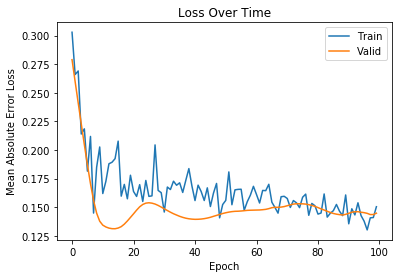

In [260]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [261]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, 1))
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        states_value = [h, c]

    return decoded_seq

In [262]:
[e_data,t_data]=create_endoder_target_pairs(data_as_array[-1])
encoder_input_data = e_data
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = t_data
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

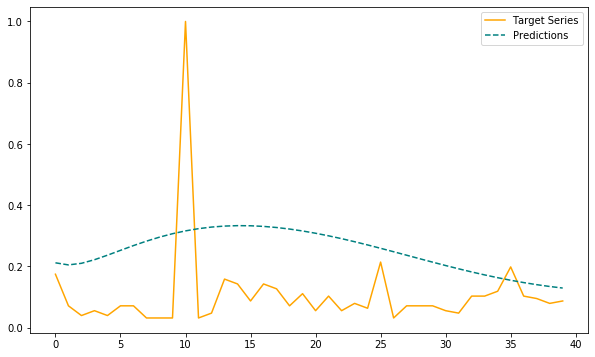

In [263]:
pred_steps=len(t_data[0])
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=51):
    encode_series = encoder_input_data[sample_ind:sample_ind+1] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data.reshape(-1,1) 
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))  
    plt.plot(target_series,color='orange')
    plt.plot(pred_series,color='teal',linestyle='--')
    
    #plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Target Series','Predictions'])
    return pred_series
preds= predict_and_plot(encoder_input_data, decoder_target_data, 0)